# Wrangling NFI Raw Data


## Libraries and Functions


In [1]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

## Load NFI Data


In [ ]:
# Load NFI Data
nfi_raw = get_latest_nfi_raw_data()
nfi_raw.shape

In [3]:
# Get df to change
nfi_final_data = nfi_raw.copy()

# Get variable information from excel sheet
sheet_nfi_org = pd.concat(
    [
        get_feature_database_sheet("NFI Original Variables"),
        get_feature_database_sheet("NFI Derivatives"),
    ]
)

# Fixing specific variables by hand -------------------------------------------
# Replace where integr is in [4L, 6A, 6H] with [4, 6, 6]
nfi_final_data["integr"] = (
    nfi_final_data["integr"].astype(str).replace(["4L", "6A", "6H"], ["4", "6", "6"])
)

# * Fix order of, 0 is lowest and 1 is highest, 4 second lowest)
nfi_final_data["dc_1"] = nfi_final_data["dc_1"].replace(
    [0, 1, 2, 3, 4], [0, 4, 3, 2, 1]
)
nfi_final_data["dc_2"] = nfi_final_data["dc_2"].replace(
    [0, 1, 2, 3, 4], [0, 4, 3, 2, 1]
)

# * For dep, remove leading 0s
nfi_final_data["dep"] = (
    nfi_final_data["dep"].astype(str).replace(r"^0+", "", regex=True)
)

# * tpespar variables...
# For tpespar1_1, remove leading 0s
nfi_final_data["tpespar1_1"] = (
    nfi_final_data["tpespar1_1"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar1_2, remove leading 0s
nfi_final_data["tpespar1_2"] = (
    nfi_final_data["tpespar1_2"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar2_1, remove leading 0s
nfi_final_data["tpespar2_1"] = (
    nfi_final_data["tpespar2_1"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar2_2, remove leading 0s
nfi_final_data["tpespar2_2"] = (
    nfi_final_data["tpespar2_2"].astype(str).replace(r"^0+", "", regex=True)
)

# * For dcespar1, remove leading 0s
nfi_final_data["dcespar1"] = (
    nfi_final_data["dcespar1"].astype(str).replace(r"^0+", "", regex=True)
)

# * For dcespar2, remove leading 0s
nfi_final_data["dcespar2"] = (
    nfi_final_data["dcespar2"].astype(str).replace(r"^0+", "", regex=True)
)

# * Fixes for 2022 data update
# * For pentexp, pcalc, pox, videplant
nfi_final_data["pentexp"] = nfi_final_data["pentexp"].replace("X", -9999).astype(float)

nfi_final_data["videplant"] = (
    nfi_final_data["videplant"].replace("X", -9999).astype(float)
)
nfi_final_data["pox"] = (
    nfi_final_data["pox"].replace(["X", ""], [-9999, -9999]).astype(float)
)
nfi_final_data["pcalc"] = (
    nfi_final_data["pcalc"].replace(["X", ""], [-9999, -9999]).astype(float)
)

# Fix variable formatting and do gapfilling of categorical variables ----------
vec_cats = []
vec_ords = []
vec_dates = []
vec_nums = []

for col in sorted(nfi_final_data.columns):
    if col in sheet_nfi_org["var"].tolist():
        if sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "cat":
            # Fix weird behaviour of some values being x and x.0
            nfi_final_data[col] = (
                nfi_final_data[col].astype(str).replace(r"\.0", "", regex=True)
            )
            # Gapfilling missing values
            nfi_final_data[col] = nfi_final_data[col].replace("nan", "Missing")
            # Set to category
            nfi_final_data[col] = nfi_final_data[col].astype("category")
            vec_cats.append(col)

        elif sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "date":
            nfi_final_data[col] = pd.to_datetime(nfi_final_data[col], errors="coerce")
            vec_dates.append(col)

        elif sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "ord":
            # nfi_final_data[col] = nfi_final_data[col].fillna(-9999)
            vec_ords.append(col)

        else:
            nfi_final_data[col] = pd.to_numeric(nfi_final_data[col], errors="coerce")
            vec_nums.append(col)


# Print information ----------------------------------------------------------
display("--- Variable Encoding: ---")
print(f" - Set to category (plus setting NA to 'missing'): \t{vec_cats}")
print(f" - Set to ordinal (plus setting NA to -9999): \t\t{vec_ords}")
print(f" - Set to datetime: \t\t\t\t\t{vec_dates}")
print(f" - Set to numeric: \t\t\t\t\t{vec_nums}")

print("Shape of nfi_final_data:", nfi_final_data.shape)
print("Number of invidiual sites:", nfi_final_data["idp"].nunique())

display("--- Columns in nfi_final_data: ----")
for col in nfi_final_data.columns:
    print(f" - {col}")

display(f"--- Shape of nfi_final_data: {nfi_final_data.shape} ---")

'--- Variable Encoding: ---'

 - Set to category (plus setting NA to 'missing'): 	['a', 'acces', 'acci', 'alive_but_injured_1', 'alive_but_injured_2', 'andain', 'autut_1', 'autut_2', 'bois_1', 'bois_2', 'bord', 'cible', 'clon', 'cover_change', 'csa_1', 'csa_2', 'cslisi', 'dcespar1', 'dcespar2', 'decoupe', 'deggib', 'dep', 'entp', 'espar', 'espar_red', 'family_lat', 'forme', 'genus_lat', 'gre', 'human_activity_var', 'humus', 'idp', 'instp5', 'integr', 'iti', 'land_use', 'land_use_change', 'mode_of_death', 'nincid_1', 'nincid_2', 'obschemin', 'obsdate', 'obshydr', 'obspedo', 'obsprof', 'obsriv', 'obsriv2', 'obsroc', 'obstopo', 'obsveget', 'ofr', 'oh', 'oln', 'olt', 'olv', 'order_lat', 'ori', 'p1525', 'p7ares', 'pcalc', 'pcalf', 'peupnr_1', 'peupnr_2', 'pgley', 'pox', 'ppseudo', 'qualite', 'revisit_state', 'roche', 'ser', 'sfcoeur', 'sfdorge_1', 'sfdorge_2', 'sfo', 'sfpied', 'simplif', 'species_lat', 'strate', 'sver', 'tetard', 'text1', 'text2', 'tige', 'topo', 'tpespar1_1', 'tpespar1_2', 'tpespar2_1', 'tpespar2_2', '

'--- Columns in nfi_final_data: ----'

 - idp
 - a
 - tree_id
 - visit_1
 - visit_2
 - revisit_state
 - hrb
 - campagne_1
 - campagne_2
 - visite_1
 - visite_2
 - c13_1
 - c13_2
 - mortb_1
 - mortb_2
 - sfdorge_1
 - sfdorge_2
 - sfgeliv_1
 - sfgeliv_2
 - sfgui_1
 - sfgui_2
 - veget
 - q1
 - q2
 - q3
 - age13
 - age
 - c0
 - htot
 - hdec
 - ddec
 - lfsd
 - v
 - w
 - r
 - ir5
 - ir1
 - espar
 - datemort
 - ori
 - tige
 - forme
 - tetard
 - cible
 - lib
 - simplif
 - acci
 - clon
 - mes_c13
 - decoupe
 - sfcoeur
 - sfpied
 - deggib
 - veget5
 - qualite
 - lon_fr
 - lat_fr
 - dep
 - ser
 - lat
 - lon
 - incid_1
 - incid_2
 - nincid_1
 - nincid_2
 - tpespar1_1
 - tpespar1_2
 - tpespar2_1
 - tpespar2_2
 - bplant_1
 - bplant_2
 - iplant_1
 - iplant_2
 - videpeuplier_1
 - videpeuplier_2
 - csa_1
 - csa_2
 - bois_1
 - bois_2
 - peupnr_1
 - peupnr_2
 - utip_1
 - utip_2
 - autut_1
 - autut_2
 - tform_1
 - tform_2
 - dc_1
 - dc_2
 - gest
 - elag
 - dpyr
 - anpyr
 - pbuis
 - dist
 - acces
 - iti
 - asperite
 - pentexp
 - portn
 - portan

'--- Shape of nfi_final_data: (1480165, 193) ---'

## Split tree and site variables


In [4]:
# Get NFI variables that are on the tree level
tree_vars = (
    get_feature_database_sheet("NFI Original Variables")
    .query("level == 'tree'")["var"]
    .tolist()
)

site_vars = (
    get_feature_database_sheet("NFI Original Variables")
    .query("level == 'location'")["var"]
    .tolist()
)

# Make sure idp is in there and remove duplicates through set
tree_vars = list(set(["idp", "tree_id", "campagne_1"] + tree_vars))
site_vars = list(set(["idp", "campagne_1"] + site_vars))

# TODO: ADDING VARIABLES HERE THAT SHOULD BE ADDED SEPARATELY WHEN MOVING FROM R TO PYTHON
site_vars = site_vars + ["lat_fr", "lon_fr", "lat", "lon"]
tree_vars = tree_vars + [
    "tree_state_1",
    "tree_state_2",
    "tree_state_change",
    "species_lat",
    "genus_lat",
    "espar_red",
    "shadow_growth",
    "tree_class",
    "family_lat",
    "order_lat",
]

# Subset vars that are actually in the data (removing automatically added _1 _2 suffixes)
tree_vars = [x for x in tree_vars if x in nfi_final_data.columns]
site_vars = [x for x in site_vars if x in nfi_final_data.columns]

# Separate tree and location variables
nfi_tree_raw = nfi_final_data[tree_vars].reset_index(drop=True)
nfi_site_raw = nfi_final_data[site_vars].drop_duplicates().reset_index(drop=True)

# Move idp to first position
nfi_tree_raw.insert(0, "idp", nfi_tree_raw.pop("idp"))
nfi_site_raw.insert(0, "idp", nfi_site_raw.pop("idp"))

# Report shapes
print("\n --- Tree Variables ---")
print(f" - Number of variables: {len(tree_vars)}")
print(f" - Number of observations: {nfi_tree_raw.shape[0]}")
print(f" - Number of unique trees: {nfi_tree_raw['tree_id'].nunique()}")
print(f" - Number of unique sites: {nfi_tree_raw['idp'].nunique()}")
print("\n --- Site Variables ---")
print(f" - Number of variables: {len(site_vars)}")
print(f" - Number of observations: {nfi_site_raw.shape[0]}")
print(f" - Number of unique sites: {nfi_site_raw['idp'].nunique()}")


 --- Tree Variables ---
 - Number of variables: 58
 - Number of observations: 1480165
 - Number of unique trees: 1480165
 - Number of unique sites: 114898

 --- Site Variables ---
 - Number of variables: 119
 - Number of observations: 116528
 - Number of unique sites: 114898


In [5]:
# Raw data has site duplicates that need to be cleaned up
# Set idp to integer for easier handling
nfi_site_raw["idp"] = nfi_site_raw["idp"].astype("int32")
# Get idp duplicates
idp_dupes = (
    nfi_site_raw[nfi_site_raw.duplicated("idp", keep=False)]
    .sort_values("idp")
    .replace("Missing", np.nan)
)
print(f" - Number of unique sites: {nfi_site_raw['idp'].nunique()}")
print(f" - Number of observations: {nfi_site_raw.shape[0]}")
print(f" - Number of duplicate sites: {idp_dupes['idp'].nunique()}")
print(f" - Number of observations in duplicate sites: {idp_dupes.shape[0]}")

 - Number of unique sites: 114898
 - Number of observations: 116528
 - Number of duplicate sites: 1630
 - Number of observations in duplicate sites: 3260


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_1078/3846878964.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Missing", np.nan)


In [6]:
# Often, lat lon NA are cause for duplicates. Check this:
dupes = idp_dupes["idp"].nunique()
coord_na_dupes = idp_dupes[idp_dupes["lat"].isna()].shape[0]

if dupes == coord_na_dupes:
    print(
        "✅ Duplicates are caused by lat/lon NA, merging them in the next cells, so no problem!"
    )
else:
    raise ValueError("❗❗❗ Duplicates are not caused by lat/lon NA, check this!")

✅ Duplicates are caused by lat/lon NA, merging them in the next cells, so no problem!


In [ ]:
#
# ! Most duplicates are due to missing values, so we can just merge them
# Define function to merge
def merge_rows(group):
    merged_values = []

    for col in group.columns:
        unique_values = group[col].dropna().unique()

        if len(unique_values) == 0:
            merged_values.append(pd.NA)
        elif len(unique_values) > 1:
            print(
                f"\nWarning: Multiple non-NA values in {col} for Group {group['idp'].iloc[0]} - Values: {unique_values} - Chosen value: {unique_values[0]} ",
            )
            merged_values.append(unique_values[0])
        else:
            merged_values.append(unique_values[0])

    return pd.Series(merged_values, index=group.columns)


# Apply function
idp_dupes_cleaned = idp_dupes.groupby("idp").apply(merge_rows).reset_index(drop=True)
nfi_site_nodupes = nfi_site_raw[~nfi_site_raw["idp"].isin(idp_dupes["idp"])]
nfi_site_nodupes = pd.concat([nfi_site_nodupes, idp_dupes_cleaned]).reset_index(
    drop=True
)
# Check if done correctly
print(f" - Number of unique sites: {nfi_site_nodupes['idp'].nunique()}")
print(f" - Number of observations: {nfi_site_nodupes.shape[0]}")
# Set idp back to category
nfi_site_nodupes["idp"] = nfi_site_nodupes["idp"].astype("category")

## Add Tree Data


### Growth Metrics


In [8]:
# Set growth threshold below which ba_1 and ba_2 are set to NA
growth_threshold = -5  # percentage

In [9]:
# NEW DF
nfi_tree_growth = nfi_tree_raw.copy()

# DBH, BA, CHANGE -------------------------------------------------------------
# Get plot area
plot_area = 25**2 * np.pi / 10**5  # (25m)^2 * pi / 10000 [m^2/ha] = [ha]

# C13
nfi_tree_growth["c13_change_abs_yr"] = (
    nfi_tree_growth["c13_2"] - nfi_tree_growth["c13_1"]
) / 5
nfi_tree_growth["c13_change_perc_yr"] = (
    nfi_tree_growth["c13_change_abs_yr"] / nfi_tree_growth["c13_1"] * 100
)

# For trees with unrealistic growth, set c13_2 to NA
# Print number of trees with unrealistic growth
df_trees_unreal_growth = nfi_tree_growth.query("c13_change_perc_yr < @growth_threshold")
df_trees_real_growth = nfi_tree_growth.query("c13_change_perc_yr >= @growth_threshold")
ntrees_unrealistic_growth = df_trees_unreal_growth.shape[0]
ptrees_unrealistic_growth = round(
    ntrees_unrealistic_growth / nfi_tree_growth.shape[0] * 100
)

print(
    f" - Number of trees with growth less than {growth_threshold}%: {ntrees_unrealistic_growth} ({ptrees_unrealistic_growth}%)",
    f"\n   For these, c13_1 and c13_2 are set to NA❗",
)

# Set c13_1, c13_2 and c13_change_perc_yr to NA if growth is below threshold
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_1"
] = np.nan
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_2"
] = np.nan
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_change_perc_yr"
] = np.nan

# Diameter
nfi_tree_growth["dbh_1"] = nfi_tree_growth["c13_1"] / np.pi
nfi_tree_growth["dbh_2"] = nfi_tree_growth["c13_2"] / np.pi
nfi_tree_growth["dbh_change_abs_yr"] = (
    nfi_tree_growth["dbh_2"] - nfi_tree_growth["dbh_1"]
) / 5
nfi_tree_growth["dbh_change_perc_yr"] = (
    nfi_tree_growth["dbh_change_abs_yr"] / nfi_tree_growth["dbh_1"] * 100
)

# Basal Area
nfi_tree_growth["ba_1"] = np.pi * (nfi_tree_growth["dbh_1"] / 2) ** 2 / plot_area
nfi_tree_growth["ba_2"] = np.pi * (nfi_tree_growth["dbh_2"] / 2) ** 2 / plot_area
nfi_tree_growth["ba_change_abs_yr"] = (
    nfi_tree_growth["ba_2"] - nfi_tree_growth["ba_1"]
) / 5
nfi_tree_growth["ba_change_perc_yr"] = (
    nfi_tree_growth["ba_change_abs_yr"] / nfi_tree_growth["ba_1"] * 100
)

# Growth rates
nfi_tree_growth["avg_growth_height_meter_per_yr"] = (
    nfi_tree_growth["htot"] / nfi_tree_growth["age13"]
)
nfi_tree_growth["avg_growth_ba_per_year"] = (
    nfi_tree_growth["ba_1"] / nfi_tree_growth["age13"]
)

# Replace inf with NA
nfi_tree_growth = nfi_tree_growth.replace([np.inf, -np.inf], np.nan)

 - Number of trees with growth less than -5%: 240 (0%) 
   For these, c13_1 and c13_2 are set to NA❗


### Age correction

- age13 is actually the age estimated at 1.30m and not the true age of the tree. To account for this, the IGN provides the following table.
- I am overwriting age13 instead of creating a new age variable so that down-stream code does not need to be changed and that age13 is the only true age variable.

| Tree Name           | ESPAR Code     | Years |
| ------------------- | -------------- | ----- |
| chêne pédonculé     | 02             | 7     |
| chêne sessile       | 03             | 8     |
| chêne pubescent     | 05             | 7     |
| chêne vert          | 06             | 6     |
| hêtre               | 09             | 9     |
| châtaignier         | 10             | 3     |
| charme              | 11             | 7     |
| bouleau verruqueux  | 12V            | 4     |
| frêne commun        | 17C            | 5     |
| autres feuillus     | other_feuillus | 5     |
| pin maritime        | 51             | 4     |
| pin sylvestre       | 52             | 7     |
| pin noir d'Autriche | 54             | 8     |
| sapin pectiné       | 61             | 9     |
| épicéa commun       | 62             | 8     |
| douglas             | 64             | 4     |
| autres résineux     | other_resineux | 6     |


In [ ]:
# Create tree_years dictionary
tree_years_dict = {
    "02": 7,
    "03": 8,
    "05": 7,
    "06": 6,
    "09": 9,
    "10": 3,
    "11": 7,
    "12V": 4,
    "17C": 5,
    "other_feuillus": 5,
    "51": 4,
    "52": 7,
    "54": 8,
    "61": 9,
    "62": 8,
    "64": 4,
    "other_resineux": 6,
    "Missing": 0,
}

# Add correction for unspecified species
for spec in nfi_tree_growth["espar"].unique():
    if spec in tree_years_dict or spec == "Missing":
        # print(f"Species: {spec} - Years: {tree_years_dict[spec]}")
        continue
    else:
        # Extract first two letters and turn into int
        first_two = int(spec[0:2])
        # Check if it is a broadleaf (<50) or needleleaf (>=50)
        if first_two < 50:
            tree_years_dict[spec] = 5
        else:
            tree_years_dict[spec] = 6

# Add to dataframe
nfi_tree_growth["add_years"] = nfi_tree_growth["espar"].map(tree_years_dict)

# Add years to age13
nfi_tree_growth["age13"] = nfi_tree_growth["age13"] + nfi_tree_growth["add_years"]

# Remove temporary columns
nfi_tree_growth = nfi_tree_growth.drop(columns=["add_years"])

# Plot histogram of tree ages
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(nfi_tree_growth["age13"], bins=30, ax=ax)
ax.set_title("Histogram of tree ages")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
plt.show()

nfi_tree_growth["age13"].describe().to_frame().T

### Size Classes


In [11]:
# AGE CLASS -------------------------------------------------------------------
nfi_tree_growth["tree_age_class"] = (
    pd.cut(
        nfi_tree_growth["age13"],
        bins=[0, 15, 30, 45, 60, 75, 100, np.Inf],
        labels=["0-15", "15-30", "30-45", "45-60", "60-75", "75-100", "100+"],
    )
    .cat.add_categories("Missing")
    .fillna("Missing")
)

# CIRCUMFERENCE CLASS -  NFI ----------------------------------------------------
# Cuts are based on IFN documentation categories
nfi_tree_growth["tree_circumference_class"] = (
    pd.cut(
        nfi_tree_growth["c13_1"],
        bins=[
            0,
            0.705,
            1.175,
            np.Inf,
        ],
        labels=["small", "medium", "large"],
    )
    .cat.add_categories(["Missing", "recruit"])
    .fillna("Missing")
)

# Set all recruits to sapling
nfi_tree_growth.loc[
    nfi_tree_growth["tree_state_change"] == "new_alive", "tree_circumference_class"
] = "recruit"

# CIRCUMFERENCE CLASS - MANUAL -------------------------------------------------

# nfi_tree_growth["tree_circumference_class_small_and_large"] = (
#     pd.cut(
#         nfi_tree_growth["c13_1"],
#         bins=[
#             0,
#             0.705,
#             1.175,
#             np.Inf,
#         ],
#         labels=["small", "medium", "large"],
#     )
#     .cat.add_categories(["Missing", "recruit"])
#     .fillna("Missing")
# )

# # Set all recruits to sapling
# nfi_tree_growth.loc[
#     nfi_tree_growth["tree_state_change"] == "new_alive", "tree_circumference_class"
# ] = "recruit"

### Social Status


In [12]:
# Calculate relative circumference of living trees
df_tmp = nfi_tree_growth.copy()
df_tmp = df_tmp.query("tree_state_1 == 'alive'")
df_tmp["c13_rel"] = df_tmp.groupby("idp", observed=False)["c13_1"].transform(
    lambda x: (x / x.mean())
)

# Separate into social status - suppressed (0) and dominant (1)
df_tmp["social_status"] = df_tmp["c13_rel"].apply(lambda x: 1 if x > 1.0 else 0)

# Dataframe for suppressed trees
df_sup = df_tmp.query("social_status != 1").copy()
df_sup["c13_rel_dominant_median"] = np.nan

# Dataframe for dominant trees
# Calculate median values within dominant trees
df_dom = df_tmp.query("social_status == 1").copy()
df_dom["c13_rel_dominant_median"] = df_dom.groupby("idp", observed=False)[
    "c13_1"
].transform(lambda x: (x / x.median()))

# Separate into social status - suppressed (0), small-dominant (1) and large-dominant (2)
df_dom["social_status"] = df_dom["c13_rel_dominant_median"].apply(
    lambda x: 2 if x > 1.0 else 1
)

New columns:
 - social_status
 - c13_rel
 - c13_rel_dominant_median


<Axes: xlabel='social_status', ylabel='c13_1'>

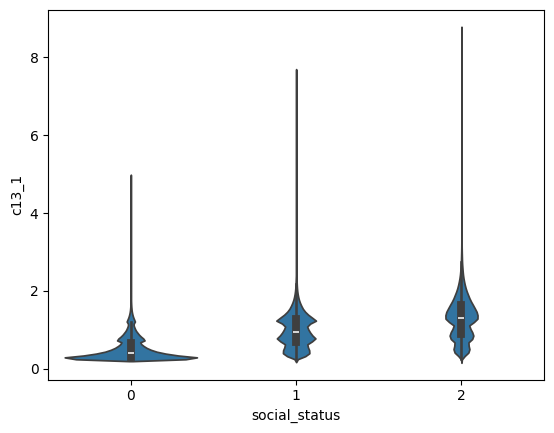

In [13]:
# Merge back to original dataframe
df_both = pd.concat([df_sup, df_dom])
df_fin = nfi_tree_growth.merge(
    df_both[["tree_id", "social_status", "c13_rel", "c13_rel_dominant_median"]],
    on="tree_id",
    how="left",
)

# Check if rows are the same
if df_fin.shape[0] != nfi_tree_growth.shape[0]:
    raise ValueError(
        f"❗❗❗ Rows are not the same, check this! df_fin = {df_fin.shape[0]} and nfi_tree_growth = {nfi_tree_growth.shape[0]}"
    )

# Check change in columns
print("New columns:")
for c in df_fin.columns:
    if c not in nfi_tree_growth.columns:
        print(f" - {c}")

# Overwrite nfi_tree_growth
nfi_tree_growth = df_fin.copy()

# Plot circumference relative to social status
sns.violinplot(data=df_both, x="social_status", y="c13_1")

## Pre-Filter Data Exploration


### Tree Level

Results:

- It looks like that for trees with substantial negative growth, that these trees had much larger c13_1 measurements compared to trees that had no negative growth. The distribution of the c13_2 measurements look similar for trees with negative growth and trees without negative growth. But there is also a tendency that c13_2 are super small. So, it is probably a mix between measurement errors of c13_1 being too large and c13_2 being too small.
  - Decision: trees below above-defined growth-threshold are set to have na for their c13_x measurements.


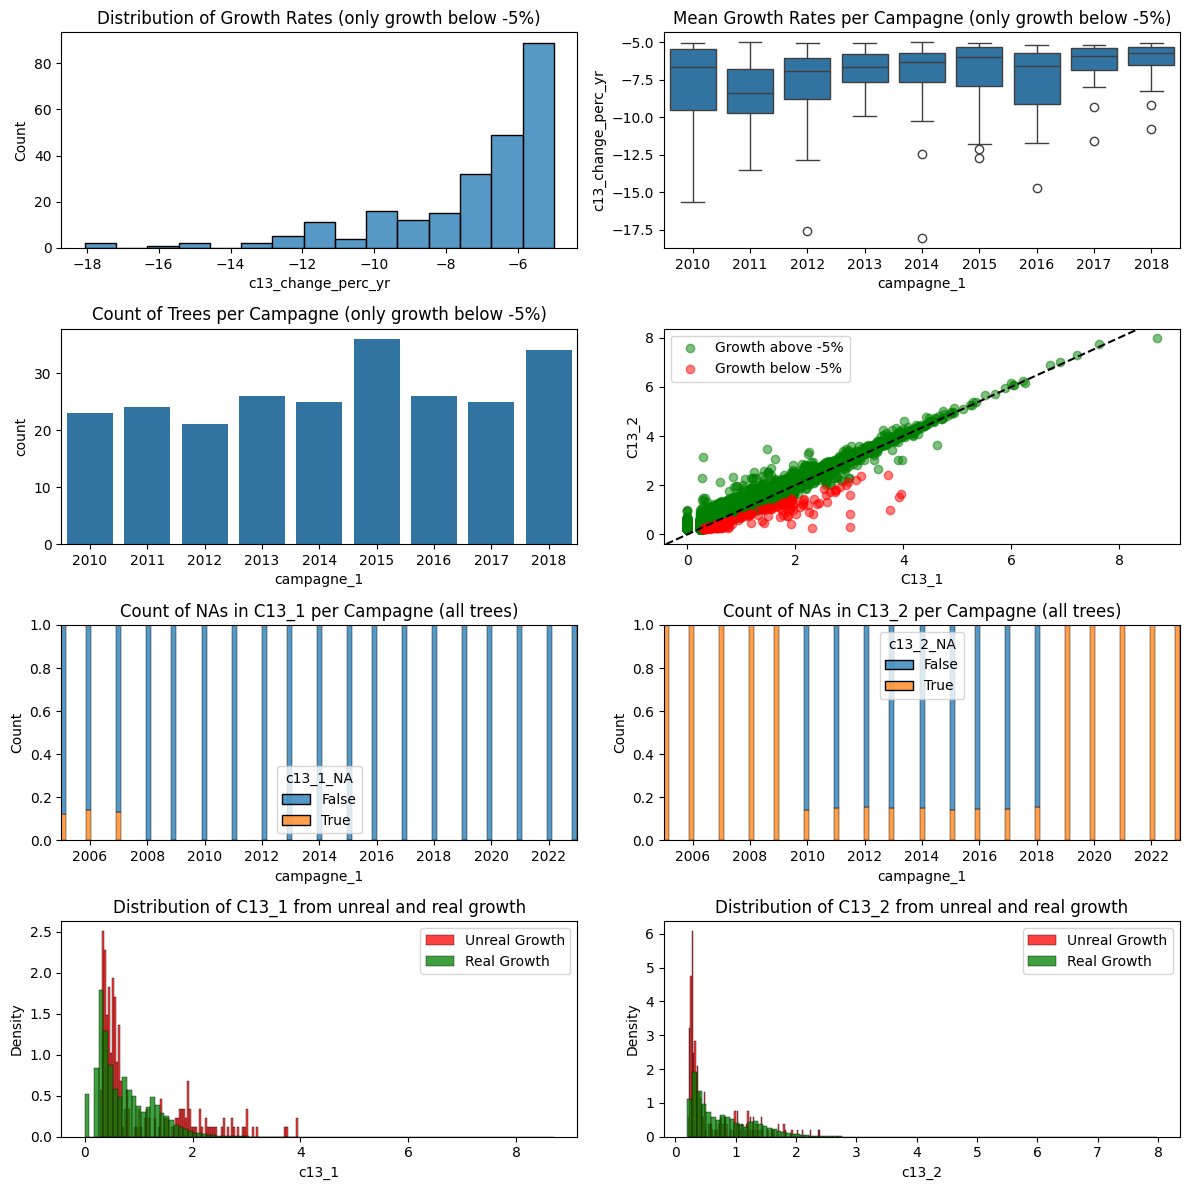

In [14]:
# INFORMATION ON UNREALISTIC GROWTH -------------------------------------------
# Create a 2x2 plot grid
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# Plot distribution of growth rates
sns.histplot(df_trees_unreal_growth["c13_change_perc_yr"], ax=axs[0, 0], stat="count")
axs[0, 0].set_title(
    f"Distribution of Growth Rates (only growth below {growth_threshold}%)"
)

# Plot the mean per campagne as boxplot
sns.boxplot(
    x="campagne_1", y="c13_change_perc_yr", data=df_trees_unreal_growth, ax=axs[0, 1]
)
axs[0, 1].set_title(
    f"Mean Growth Rates per Campagne (only growth below {growth_threshold}%)"
)

# Add count on top of boxplot
sns.countplot(x="campagne_1", data=df_trees_unreal_growth, ax=axs[1, 0])
axs[1, 0].set_title(
    f"Count of Trees per Campagne (only growth below {growth_threshold}%)"
)

# Compare C13_1 and C13_2
axs[1, 1].scatter(
    df_trees_real_growth["c13_1"],
    df_trees_real_growth["c13_2"],
    color="green",
    label=f"Growth above {growth_threshold}%",
    alpha=0.5,
)
axs[1, 1].scatter(
    df_trees_unreal_growth["c13_1"],
    df_trees_unreal_growth["c13_2"],
    color="red",
    label=f"Growth below {growth_threshold}%",
    alpha=0.5,
)
axs[1, 1].set_xlabel("C13_1")
axs[1, 1].set_ylabel("C13_2")
axs[1, 1].legend()
axs[1, 1].axline((0, 0), slope=1, color="black", linestyle="--")

# Get counts of NAs in C13_1 and C13_2 per campagne
df_tmp = nfi_tree_growth.copy()
df_tmp["c13_1_NA"] = df_tmp["c13_1"].isna()
df_tmp["c13_2_NA"] = df_tmp["c13_2"].isna()

# Plot these counts per campagne
sns.histplot(
    x="campagne_1",
    hue="c13_1_NA",
    data=df_tmp,
    ax=axs[2, 0],
    multiple="fill",
    stat="count",
)

axs[2, 0].set_title(f"Count of NAs in C13_1 per Campagne (all trees)")

sns.histplot(
    x="campagne_1",
    hue="c13_2_NA",
    data=df_tmp,
    ax=axs[2, 1],
    multiple="fill",
    stat="count",
)
axs[2, 1].set_title(f"Count of NAs in C13_2 per Campagne (all trees)")


# Plot distribution of c13_1 in df_trees_unreal_growth
sns.histplot(
    df_trees_unreal_growth["c13_1"], stat="density", color="red", bins=100, ax=axs[3, 0]
)
sns.histplot(
    df_trees_real_growth["c13_1"], stat="density", color="green", bins=100, ax=axs[3, 0]
)
axs[3, 0].set_title("Distribution of C13_1 from unreal and real growth")
axs[3, 0].legend(["Unreal Growth", "Real Growth"])

# Plot distribution of c13_2 in df_trees_unreal_growth
sns.histplot(
    df_trees_unreal_growth["c13_2"], stat="density", color="red", bins=100, ax=axs[3, 1]
)
sns.histplot(
    df_trees_real_growth["c13_2"], stat="density", color="green", bins=100, ax=axs[3, 1]
)
axs[3, 1].set_title("Distribution of C13_2 from unreal and real growth")
axs[3, 1].legend(["Unreal Growth", "Real Growth"])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_1078/2008147509.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nfi_tree_growth.groupby(["tree_state_change", "campagne_1"])


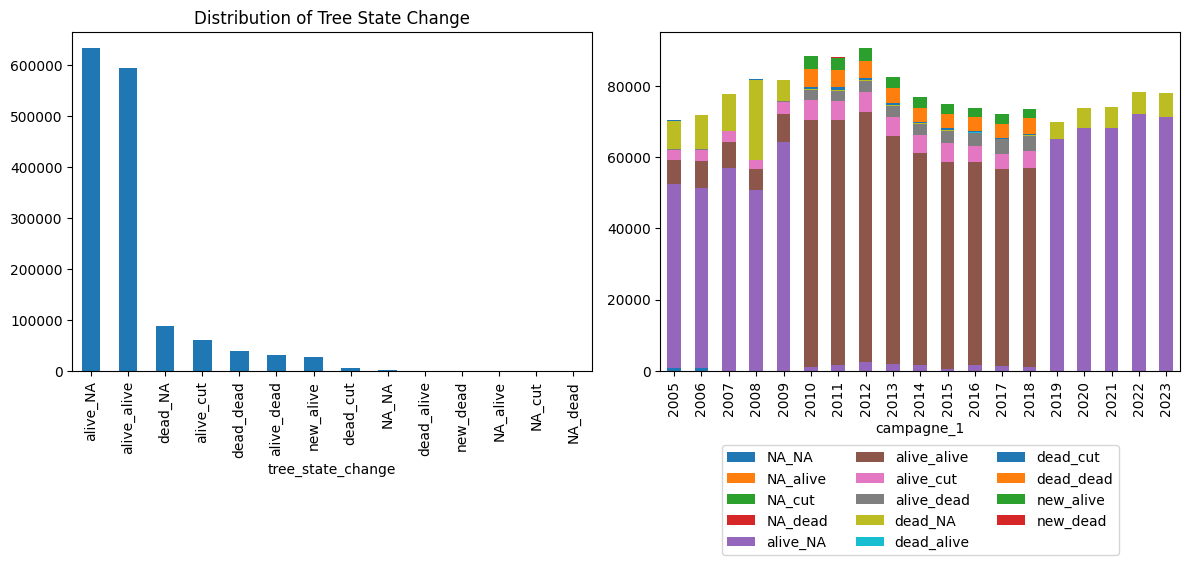

In [15]:
# INFORMATION ON TREE STATE ----------------------------------------------------
# Drop tree_state_change without any counts
nfi_tree_growth["tree_state_change"] = (
    nfi_tree_growth["tree_state_change"].astype(str).astype("category")
)

# Create a 2x1 plot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Distribution of tree_state_change
nfi_tree_growth["tree_state_change"].value_counts().plot(kind="bar", ax=axs[0])
axs[0].set_title("Distribution of Tree State Change")

(
    nfi_tree_growth.groupby(["tree_state_change", "campagne_1"])
    .size()
    .reset_index()
    .pivot(columns="tree_state_change", index="campagne_1", values=0)
    .plot(kind="bar", stacked=True, ax=axs[1])
)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

fig.tight_layout()
plt.show()

### Site Level


<Axes: xlabel='campagne_1'>

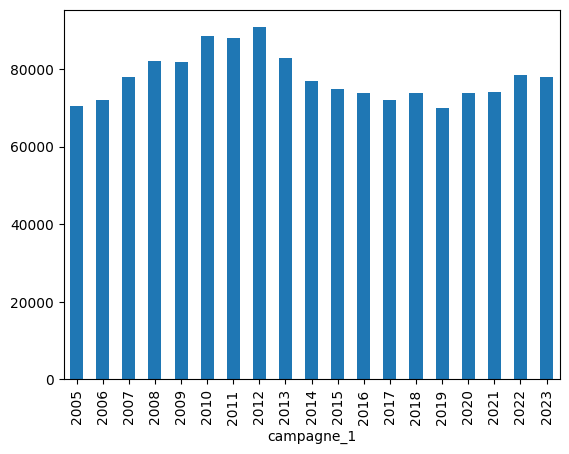

In [16]:
# Counted trees per campagne
nfi_tree_growth.campagne_1.value_counts().sort_index().plot(kind="bar")

<Axes: xlabel='campagne_1'>

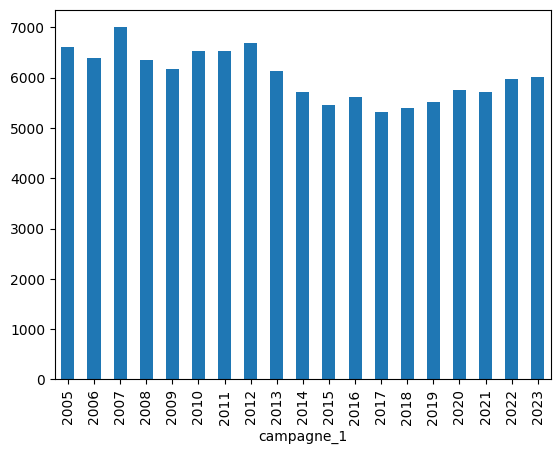

In [17]:
# Counted sites per campagne
nfi_site_nodupes.campagne_1.value_counts().sort_index().plot(kind="bar")

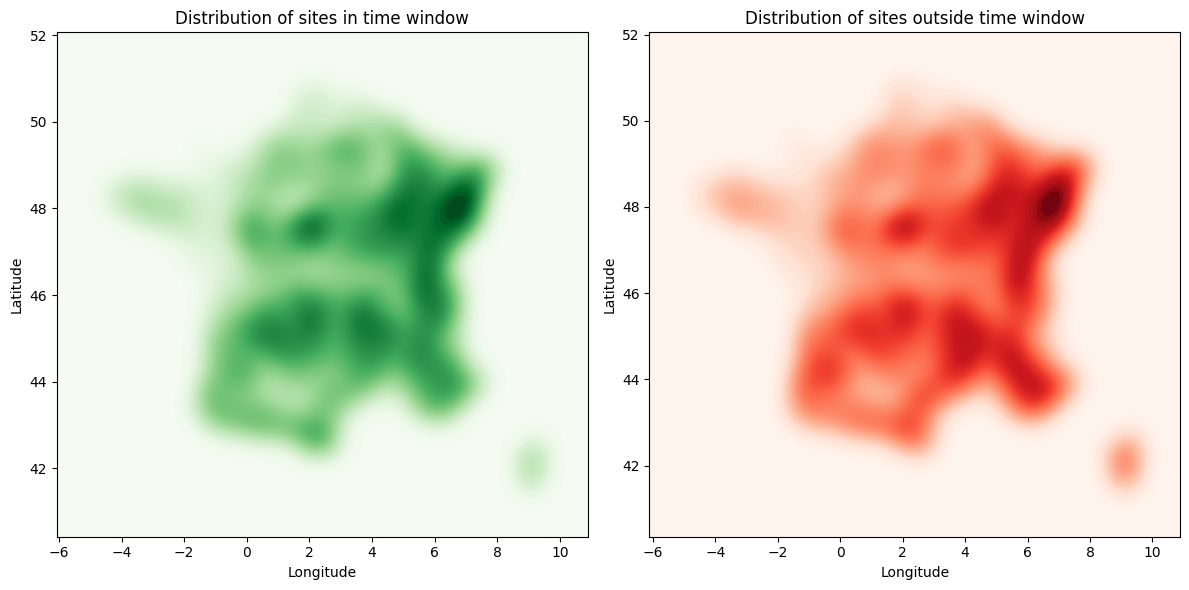

In [18]:
# Check if distribution of sites across France is similar in our time-window as in remaining time
# Subset tree and site dataframe
tmp_tree = nfi_tree_growth[["idp", "tree_id", "campagne_1"]].reset_index(drop=True)
tmp_site = nfi_site_nodupes[
    ["idp", "campagne_1", "lat", "lon", "lat_fr", "lon_fr"]
].reset_index(drop=True)

# Make sure idp is numeric for merging...
tmp_tree["idp"] = tmp_tree["idp"].astype("int32")
tmp_site["idp"] = tmp_site["idp"].astype("int32")

df_tmp = pd.merge(tmp_tree, tmp_site, on=["idp", "campagne_1"], how="left")

df_intime = df_tmp.query("campagne_1 >= 2010 & campagne_1 <= 2016")[
    ["idp", "lat", "lon"]
].drop_duplicates()
df_outsidetime = df_tmp.query("campagne_1 < 2010 | campagne_1 > 2016")[
    ["idp", "lat", "lon"]
].drop_duplicates()

# Plot intime
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(
    data=df_intime,
    x="lon",
    y="lat",
    fill=True,
    cmap="Greens",
    ax=axs[0],
    thresh=0,
    levels=150,
    # cbar=True,
)
axs[0].set_title("Distribution of sites in time window")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# Plot outsidetime
sns.kdeplot(
    data=df_outsidetime,
    x="lon",
    y="lat",
    fill=True,
    cmap="Reds",
    ax=axs[1],
    thresh=0,
    levels=150,
    # cbar=True,
)
axs[1].set_title("Distribution of sites outside time window")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")

fig.tight_layout()
plt.show()

**Investigate Simplified Trees**


'Shape of simplified trees from 2009-2016: (264423, 75)'

tree_state_change
alive_alive    225957
alive_cut       19633
alive_dead      14646
alive_NA         4187
NA_NA               0
NA_alive            0
NA_cut              0
NA_dead             0
dead_NA             0
dead_alive          0
dead_cut            0
dead_dead           0
new_alive           0
new_dead            0
Name: count, dtype: int64

Number of trees per site: 


<Axes: xlabel='n_trees'>

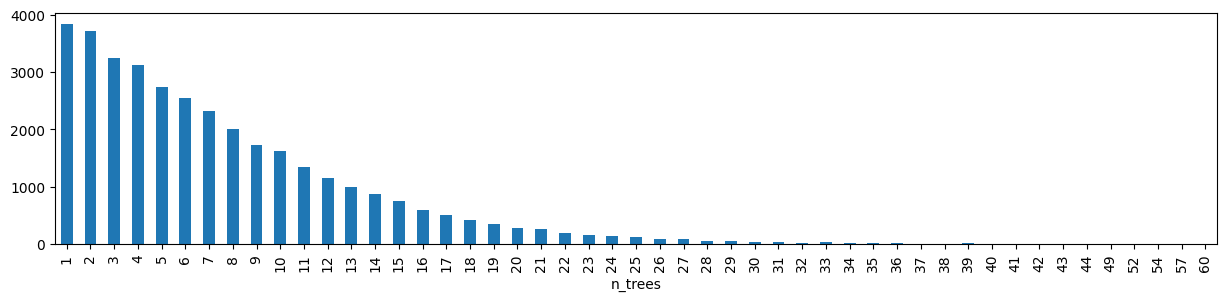

In [19]:
# For simplified trees, do they have NA in ba_1 and ba_2?
# Get timespan of interest
df_timespan = nfi_tree_growth.copy().query("campagne_1 >= 2010 & campagne_1 <= 2018")
df_timespan["idp"] = df_timespan["idp"].astype("int32")
df_timespan.insert(0, "tree_id", df_timespan.pop("tree_id"))
# Split into simplified and non-simplified trees
df_simplified_trees = df_timespan.query("simplif == '1'")
df_nonsimplified_trees = df_timespan.query("simplif != '1'")

display(f"Shape of simplified trees from 2009-2016: {df_simplified_trees.shape}")
display(df_simplified_trees.tree_state_change.value_counts())
# display(df_simplified_trees.campagne_1.value_counts().sort_index())
# display(
#     df_simplified_trees[["campagne_1", "tree_state_change"]].value_counts().sort_index()
# )
df_simplified_trees[["ba_1", "ba_2"]].isna().value_counts(dropna=False)
# * Only 10 percent of all simplified trees have no ba_2 values. So they can still be useful!

# Number of trees per site
df_tmp = df_simplified_trees.groupby("idp").size().reset_index()
df_tmp.columns = ["idp", "n_trees"]
print("Number of trees per site: ")
display(df_tmp.n_trees.value_counts().sort_index().plot(kind="bar", figsize=(15, 3)))

In [20]:
# What are these sites with more than 20 trees?
# * Looks all good to me...
# df_tmp.query("n_trees > 20").sort_values("n_trees", ascending=False).head(10)
# df_simplified_trees.query("idp == 625259")

In [21]:
# Are simplified trees not assessed on damage?
# * No, they are generally assessed on damage...
df_simplified_trees.value_counts("acci", dropna=False).sort_index()
df_simplified_trees.value_counts("deggib", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgui_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgui_2", dropna=False).sort_index()
df_simplified_trees.value_counts("sfdorge_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfdorge_2", dropna=False).sort_index()
df_simplified_trees.value_counts("sfcoeur", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgeliv_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgeliv_2", dropna=False).sort_index()

sfgeliv_2
0.0     10010
1.0        70
2.0        12
NaN    254331
Name: count, dtype: int64

In [22]:
# Are some species more simplified than others?
# * There are minor differences, but generally the top 10 species are the same.
print(f"Non simplified trees (total = {df_nonsimplified_trees.shape[0]}):")
display(
    df_nonsimplified_trees["genus_lat"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .head(10)
    / df_nonsimplified_trees.shape[0]
    * 100
)
print(f"Simplified trees (total = {df_simplified_trees.shape[0]}):")
display(
    df_simplified_trees["genus_lat"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .head(10)
    / df_simplified_trees.shape[0]
    * 100
)

Non simplified trees (total = 457346):


genus_lat
Quercus     25.453595
Pinus       11.114998
Fagus        8.933062
Castanea     6.845364
Carpinus     6.016451
Abies        5.177262
Picea        5.057877
Fraxinus     4.549728
Acer         3.416232
Populus      3.227316
Name: count, dtype: float64

Simplified trees (total = 264423):


genus_lat
Quercus        25.791251
Pinus          11.368905
Carpinus       11.326171
Castanea        8.482621
Fagus           7.602213
Picea           5.418212
Abies           4.302198
Fraxinus        3.416117
Pseudotsuga     2.780772
Acer            2.564830
Name: count, dtype: float64

---

## Apriori Filter of Sites and Trees

Notes on the filters below:

- Filters to apply to reduce computational load + get more representative results when calculating site-level metrics.
- Between 2009-2016, peupnr_2 is never 3 (temporarily forested). So, filtering for peupnr_2 =! 3 does not remove any clear-cut sites.


#### Sites


In [23]:
# SITE FILTER
df_aft = nfi_site_nodupes.copy()

# Filter for campagne of interest
first_year = 2010
last_year = 2018
df_bef = df_aft.copy()
df_aft = df_bef.query("campagne_1 >= @first_year and campagne_1 <= @last_year")
filter_report(f"campagne_1 {first_year}-{last_year}", df_bef, df_aft, site_level=True)

# Filter based on peupnr_x (0 = censusable, 1 = not censusable, 3 = temporarily deforested)
df_bef = df_aft.copy()
df_aft = df_bef.query("peupnr_1 not in ['1', '3']")
filter_report("Censuable sites (peupnr_1)", df_bef, df_aft, site_level=True)

df_bef = df_aft.copy()
df_aft = df_bef.query("peupnr_2 not in ['1', '3']")
filter_report("Censuable sites (peupnr_2)", df_bef, df_aft, site_level=True)

# Removing NA coords lat/lon
df_bef = df_aft.copy()
df_aft = df_bef.dropna(subset=["lat", "lon"])
filter_report("Removing NA coords lat/lon", df_bef, df_aft, site_level=True)

# Final Report
nfi_site_filtered = df_aft.reset_index(drop=True)
filter_report("-- Final", nfi_site_nodupes, nfi_site_filtered, site_level=True)

# Reset dtypes to remove dropped levels
nfi_site_filtered["peupnr_1"] = nfi_site_filtered["peupnr_1"].astype("category")
nfi_site_filtered["peupnr_2"] = nfi_site_filtered["peupnr_2"].astype("category")

 - Filter: campagne_1 2010-2018           |	Sites from 114898 to 53387 (=      61511, 54%)	|	 ❗More than 5% of sites removed❗
 - Filter: Censuable sites (peupnr_1)     |	Sites from 53387 to 52666 (=        721, 1%)	|	 
 - Filter: Censuable sites (peupnr_2)     |	Sites from 52666 to 51833 (=        833, 2%)	|	 
 - Filter: Removing NA coords lat/lon     |	Sites from 51833 to 51413 (=        420, 1%)	|	 
 - Filter: -- Final                       |	Sites from 114898 to 51413 (=      63485, 55%)	|	 ❗More than 5% of sites removed❗


##### Save Coordinates for Extraction


In [24]:
#
# ! Note: Save the idp, census year, and coordinates for these sites.
# ! This file is then used for all extractions!
# ! Filters down the line, may remove some sites, but keeping them in here makes it more flexible for a general data extraction without going back-and-forth again.

sites_with_idp = (
    nfi_site_filtered[["idp", "campagne_1", "lat", "lon", "lat_fr", "lon_fr"]]
    .drop_duplicates()
    .reset_index()
)

sites_with_idp.columns = ["SiteID", "idp", "first_year", "y", "x", "y_fr", "x_fr"]

sites_without_idp = (
    sites_with_idp.copy()
    .drop(["idp", "first_year", "SiteID"], axis=1)
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()  # Needs double index reset for some reason...
    .rename(columns={"index": "SiteID"})
)

os.makedirs(here("data/final/nfi"), exist_ok=True)
sites_with_idp.to_csv(here("data/final/nfi/coords_of_sites_with_idp.csv"), index=False)
sites_without_idp.to_csv(
    here("data/final/nfi/coords_of_sites_without_idp.csv"), index=False
)

In [25]:
# Save as geojson
import geopandas as gpd
from shapely.geometry import Point

# Fixing dtypes
sites_with_idp["idp"] = sites_with_idp["idp"].astype("int32")

# For EPSG 4326, WGS84
geometry = [Point(xy) for xy in zip(sites_with_idp.x, sites_with_idp.y)]
sites_epsg4326 = gpd.GeoDataFrame(sites_with_idp, geometry=geometry)
sites_epsg4326.crs = "EPSG:4326"
sites_epsg4326.to_file(
    here("data/final/nfi/sites_with_idp_epsg4326.geojson"), driver="GeoJSON"
)

# For EPSG 2154, RGF93 / Lambert-93
geometry = [Point(xy) for xy in zip(sites_with_idp.x_fr, sites_with_idp.y_fr)]
sites_epsg2154 = gpd.GeoDataFrame(sites_with_idp, geometry=geometry)
sites_epsg2154 = sites_epsg2154[["idp", "first_year", "geometry"]]
sites_epsg2154.crs = "EPSG:2154"
sites_epsg2154.to_file(
    here("data/final/nfi/sites_with_idp_epsg2154.geojson"), driver="GeoJSON"
)

#### Trees


In [26]:
# TREE FILTER
# New df
df_bef = nfi_tree_growth.copy()

# Reduce to idp that are in nfi_site_filtered
nfi_site_nodupes["idp"] = nfi_site_nodupes["idp"].astype(int)

df_bef["idp"] = df_bef["idp"].astype(int)
df_aft = df_bef[df_bef["idp"].isin(nfi_site_filtered["idp"].tolist())]
filter_report("Reduce to idp in nfi_site_filtered", df_bef, df_aft)

# Remove where shadow growth is 'yes'
# * This was done in R, not done anymore.
# * But this does not change anything because it only
# * removes trees measured outside our time of interest
# df_bef = df_aft.copy()
# df_aft = df_bef.query("shadow_growth != 'yes'")
# filter_report("Remove trees wi. shadow growth", df_bef, df_aft)

# Remove trees with unknown tree status
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_1 != 'Missing'")
filter_report("Remove tree_state_1 missing", df_bef, df_aft)

df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_2 != 'Missing'")
filter_report("Remove tree_state_2 missing", df_bef, df_aft)

# Remove trees with non-sensical tree state change
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_change != 'dead_alive'")
filter_report("Remove state_change dead_alive", df_bef, df_aft)

# Remove recruits that died
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_change != 'new_dead'")
filter_report("Remove state_change new_dead", df_bef, df_aft)

# Remove trees that were certainly outside of the target stand
df_bef = df_aft.copy()
df_aft = df_bef.query("cible != '0'")
filter_report("Remove cible", df_bef, df_aft)

# Remove trees with simplified measurement
# ! This removes only 10 sites but ~33% of all trees! This limits our analysis a lot!
# df_bef = df_aft.copy()
# df_aft = df_bef.query("simplif != '1'")
# filter_report("Remove simplified trees", df_bef, df_aft)

# Final Report
nfi_filter_trees = df_aft.reset_index(drop=True)
filter_report("-- Final", nfi_tree_growth, nfi_filter_trees)

# Reset dtypes to remove dropped levels
# nfi_filter_trees["shadow_growth"] = nfi_filter_trees[
#     "shadow_growth"
# ].cat.remove_unused_categories()
nfi_filter_trees["tree_state_1"] = nfi_filter_trees[
    "tree_state_1"
].cat.remove_unused_categories()
nfi_filter_trees["tree_state_2"] = nfi_filter_trees[
    "tree_state_2"
].cat.remove_unused_categories()
nfi_filter_trees["tree_state_change"] = nfi_filter_trees[
    "tree_state_change"
].cat.remove_unused_categories()

 - Filter: Reduce to idp in nfi_site_filtered |	Sites from 114898 to 51413 (=      63485, 55%)	|	 Trees from 1480165 to 706937 (= 773228, 52%) ❗More than 5% of sites removed❗ ❗More than 5% of trees removed❗
 - Filter: Remove tree_state_1 missing    |	Sites from 51413 to 51413 (=          0, 0%)	|	 Trees from 706937 to 706937 (=     0, 0%)  
 - Filter: Remove tree_state_2 missing    |	Sites from 51413 to 50231 (=       1182, 2%)	|	 Trees from 706937 to 693550 (= 13387, 2%)  
 - Filter: Remove state_change dead_alive |	Sites from 50231 to 50229 (=          2, 0%)	|	 Trees from 693550 to 693193 (=   357, 0%)  
 - Filter: Remove state_change new_dead   |	Sites from 50229 to 50229 (=          0, 0%)	|	 Trees from 693193 to 693014 (=   179, 0%)  
 - Filter: Remove cible                   |	Sites from 50229 to 50129 (=        100, 0%)	|	 Trees from 693014 to 687624 (=  5390, 1%)  
 - Filter: -- Final                       |	Sites from 114898 to 50129 (=      64769, 56%)	|	 Trees from 1480165 

In [27]:
# Reduce sites only to sites that were kept after filtering trees
nfi_site_filtered = nfi_site_filtered[
    nfi_site_filtered["idp"].isin(nfi_filter_trees["idp"].unique())
].reset_index(drop=True)

nfi_site_filtered.shape

(50129, 119)

## Additional Information (after filter to speed things up)


### Tree-level


In [28]:
# Get temporary df
nfi_tree_addinfo = nfi_filter_trees.copy()

##### Height Estimation


In [29]:
# Check for how many trees htot is missing
print("Dataset lacks HEIGHT for % of trees: ")

for state in nfi_tree_addinfo["tree_state_change"].unique():
    print(
        f" - {state:<15}: {round(nfi_tree_addinfo.query('tree_state_change == @state')['htot'].isna().sum() / nfi_tree_addinfo.query('tree_state_change == @state').shape[0] * 100, 2)}%"
    )

print("\nDataset lacks VOLUME for % of trees: ")

for state in nfi_tree_addinfo["tree_state_change"].unique():
    print(
        f" - {state:<15}: {round(nfi_tree_addinfo.query('tree_state_change == @state')['v'].isna().sum() / nfi_tree_addinfo.query('tree_state_change == @state').shape[0] * 100, 2)}%"
    )

Dataset lacks HEIGHT for % of trees: 
 - new_alive      : 0.15%
 - alive_alive    : 40.58%
 - alive_cut      : 40.99%
 - alive_dead     : 48.88%
 - dead_dead      : 80.76%
 - dead_cut       : 83.11%

Dataset lacks VOLUME for % of trees: 
 - new_alive      : 100.0%
 - alive_alive    : 0.0%
 - alive_cut      : 0.0%
 - alive_dead     : 0.0%
 - dead_dead      : 0.0%
 - dead_cut       : 0.0%


In [30]:
# Random Forest to predict htot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Get only trees with htot
df_tmp = nfi_tree_addinfo.merge(nfi_site_filtered, how="left", on="idp")[
    [
        "tree_id",
        "c13_1",
        "lat_fr",
        "lon_fr",
        "espar",
        "genus_lat",
        "simplif",
        "tree_state_change",
        "age13",
        "idp",
        "ir5",
        "w",
        "v",
        "htot",
        "tetard",  # Whether tree is a cut constantly
    ]
]

# Filter down to trees that were alive at first visit
# Note: There are many dead trees with weirdly small htot (maybe the fell or something)
# So, I am only focusing on alive trees. Should be kept in mind for later calcualtions!
df_tmp = df_tmp.query("tree_state_change in ['alive_alive', 'alive_cut', 'alive_dead']")

# OHE espar and simplif
df_tmp = pd.get_dummies(
    df_tmp,
    columns=["espar", "simplif", "genus_lat", "tree_state_change", "tetard"],
    drop_first=True,
)

# Get dictionary for OHE
ohe_dict = {
    "espar": df_tmp.filter(like="espar").columns,
    "simplif": df_tmp.filter(like="simplif").columns,
    "genus_lat": df_tmp.filter(like="genus_lat").columns,
    "tree_state_change": df_tmp.filter(like="tree_state_change").columns,
    "tetard": df_tmp.filter(like="tetard").columns,
}

# Drop NAs
df_rf = df_tmp.copy()
df_rf = df_rf.dropna()

# Split into predictors and response
X = df_rf.drop(columns=["htot", "tree_id"])
y = df_rf["htot"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    # stratify=vec_strat,
)

# Train model with best parameters
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

my_grid = {
    "n_estimators": [100, 200, 1000],
    "max_depth": [1, 5, 10],
    "max_features": ["sqrt", 0.1, 0.05],
}

# rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# grid_search = GridSearchCV(
#     rf, param_grid=my_grid, cv=5, scoring="neg_mean_squared_error", verbose=2
# )
# grid_search.fit(X_train, y_train)

# # Get best parameters
# grid_search.best_params_

# # Report best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_} (RMSE)")

# Do CV with best parameters
from sklearn.model_selection import cross_val_score

# best_params = {"max_depth": 10, "max_features": 0.1, "n_estimators": 1000}
best_params = {"n_estimators": 100}

rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
)

rmse_scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
)
rmse_scores = np.sqrt(-rmse_scores)
r2_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="r2")

# Report
print("Train performance:")
print(f"RMSE: {rmse_scores.mean():.2f} +/- {rmse_scores.std():.2f}")
print(f"R2: {r2_scores.mean():.2f} +/- {r2_scores.std():.2f}")

# Fit
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Get variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
names = X.columns[indices]

# Get RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))
r2 = rf.score(X_test, y_test)

# Report
print("\nTest performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

Train performance:
RMSE: 1.33 +/- 0.02
R2: 0.97 +/- 0.00

Test performance:
RMSE: 1.28
MAE: 0.88
R2: 0.97


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_1078/142486589.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


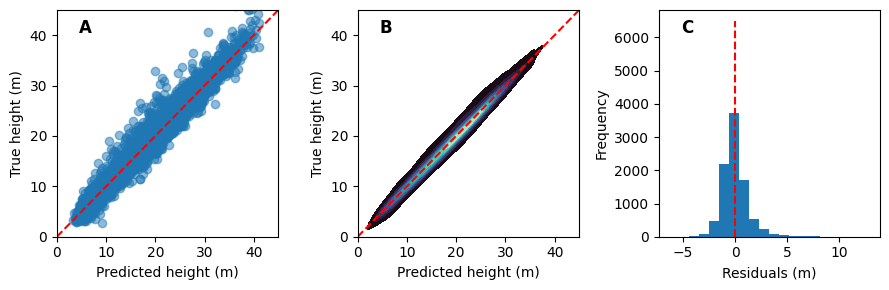

In [ ]:
import string

# Make one scatter and one kde plot side by side
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Scatter
axs[0].scatter(y_pred, y_test, alpha=0.5)
axs[0].plot([0, 45], [0, 45], color="red", linestyle="--")
axs[0].set_xlim(0, 45)
axs[0].set_ylim(0, 45)
axs[0].set_xlabel("Predicted height (m)")
axs[0].set_ylabel("True height (m)")

# KDE
sns.kdeplot(
    x=y_pred,
    y=y_test,
    fill=True,
    thresh=0.05,
    levels=10,
    cmap="mako",
    ax=axs[1],
)
axs[1].plot([0, 45], [0, 45], color="red", linestyle="--")
axs[1].set_xlim(0, 45)
axs[1].set_ylim(0, 45)
axs[1].set_xlabel("Predicted height (m)")
axs[1].set_ylabel("True height (m)")

# Residuals Histogram
residuals = y_test - y_pred
axs[2].hist(residuals, bins=20)
axs[2].plot([0, 0], [0, 6500], color="red", linestyle="--")
axs[2].set_xlabel("Residuals (m)")
axs[2].set_ylabel("Frequency")

# Give each subplot a letter
for i, ax in enumerate(axs):
    ax.text(
        0.1,
        0.9,
        string.ascii_uppercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# fig.suptitle(
#     f"Prediction of Tree Height [m] \n RMSE: {round(rmse,1)} | MAE: {round(mae,1)} | R2: {round(r2, 2)}",
#     fontsize=14,
#     fontweight="bold",
# )

plt.tight_layout()
plt.savefig(here("./rf_height_prediction.png"), dpi=300)
fig.show()

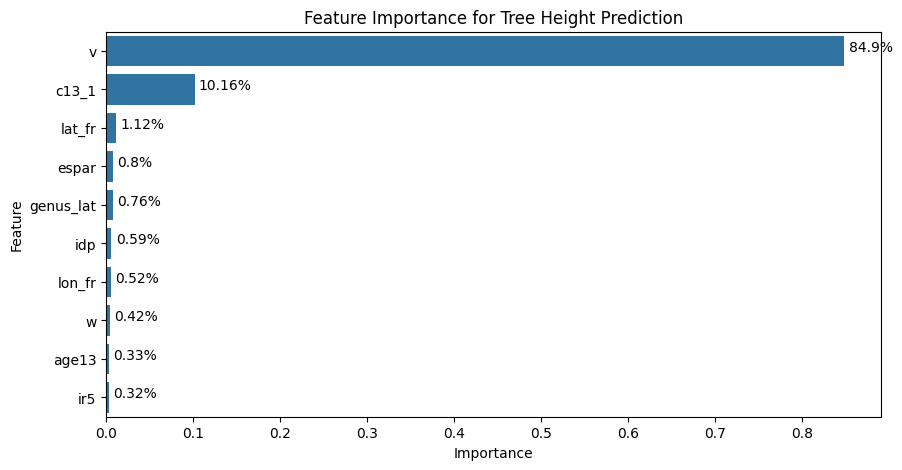

In [32]:
# Get feature importance
fi = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": rf.feature_importances_,
    }
)

# Sum up importance for species and genus
agg_vars = []
for col in ohe_dict.keys():
    agg_vars.append(
        pd.DataFrame(
            {
                "feature": col,
                "importance": fi.query(f"feature in @ohe_dict[@col]")[
                    "importance"
                ].sum(),
            },
            index=[0],
        )
    )
agg_vars = pd.concat(agg_vars)
agg_vars
fi = pd.concat([fi, agg_vars]).reset_index(drop=True)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x="importance",
    y="feature",
    data=fi.sort_values("importance", ascending=False).head(10),
    ax=ax,
)

# Add percentages to the right
for i in ax.patches:
    ax.text(
        i.get_width() + 0.005,
        i.get_y() + i.get_height() / 2,
        f"{round(i.get_width()*100, 2)}%",
        fontsize=10,
        color="black",
    )

ax.set_title("Feature Importance for Tree Height Prediction")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.show()

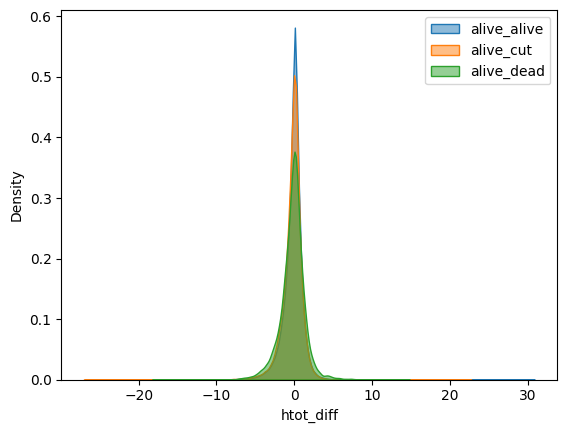

tree_state_change  htot_replaced_by_prediction
alive_alive        False                          53.0
                   True                           36.0
alive_cut          False                           4.0
                   True                            2.0
alive_dead         False                           2.0
                   True                            2.0
Name: proportion, dtype: float64

In [33]:
import seaborn as sns

# Use model to predict htot for all trees
X_all = df_tmp.drop(columns=["htot", "tree_id"])
y_all = df_tmp["htot"]

# Predict
y_pred_all = rf.predict(X_all)

# Add to dataframe
df_estimated_htot = df_tmp.copy()
df_estimated_htot["htot_pred"] = y_pred_all

# Calculate difference between predicted and true htot
df_estimated_htot["htot_diff"] = (
    df_estimated_htot["htot_pred"] - df_estimated_htot["htot"]
)

# Record where htot is replaced by predicted htot
# Replace where htot is missing
# Replace where tree_state_change is alive_alive, alive_cut, or alive_dead
df_estimated_htot["htot_replaced_by_prediction"] = df_estimated_htot["htot"].isna()


# Attach relevant columns from nfi_tree_addinfo
df_estimated_htot = df_estimated_htot.merge(
    nfi_tree_addinfo[
        [
            "tree_id",
            "tree_state_change",
            "tree_circumference_class",
            "tree_class",
            "genus_lat",
            "campagne_1",
            "dbh_1",
        ]
    ],
    on="tree_id",
    how="left",
)

# Plot distribution of difference per tree_state_change
for class_ in df_estimated_htot["tree_state_change"].unique():
    df_i = df_estimated_htot.query("tree_state_change == @class_")
    sns.kdeplot(df_i["htot_diff"], label=class_, fill=True, alpha=0.5)

plt.legend()
plt.show()

# Print number of trees with htot replaced by prediction
display(
    round(
        df_estimated_htot[["tree_state_change", "htot_replaced_by_prediction"]]
        .value_counts(normalize=True)
        .sort_index()
        * 100
    )
)

# Replace and clean -----------------------------------------------------------

# Replace htot with predicted htot where htot is missing and where tree is alive_alive, alive_cut, or alive_dead
df_estimated_htot["htot_final"] = df_estimated_htot["htot"]
conditions = (df_estimated_htot["htot_final"].isna()) & (
    df_estimated_htot["tree_state_change"].isin(
        ["alive_alive", "alive_cut", "alive_dead"]
    )
)
df_estimated_htot.loc[conditions, "htot_final"] = df_estimated_htot.loc[
    conditions, "htot_pred"
]

# Reduce df to make easier to read
df_biomass = df_estimated_htot.copy()[
    [
        "tree_id",
        "htot",
        "htot_pred",
        "htot_diff",
        "htot_final",
        "htot_replaced_by_prediction",
        "tree_state_change",
        "c13_1",
        "dbh_1",
        "genus_lat",
        "tree_class",
        "v",
    ]
]

# Calculation of Volume not needed because already given in the dataset...
# # Calculate biomass for each tree
# df_biomass["volume_calc"] = (
#     (math.pi / 40.0)
#     * df_biomass["dbh_1"]
#     * df_biomass["dbh_1"]
#     * df_biomass["htot_final"]
# )

# # Compare volume_calc with measured volume
# df_biomass["volume_diff"] = df_biomass["v"] - df_biomass["volume_calc"]

# # Plot distribution of difference per tree_state_change
# for class_ in df_biomass["tree_state_change"].unique():
#     df_i = df_biomass.query("tree_state_change == @class_")
#     sns.kdeplot(df_i["volume_diff"], label=class_, fill=True, alpha=0.5)

# plt.legend()
# plt.show()

In [34]:
# Note: There are a few trees with extremely low height values, even for alive trees
# I am not sure what is off with these, maybe tetards (nope, checked it...)
# Anyways, there is no reason to remove these variables, so I keep them and acknowledge their noise.
df_biomass.sort_values("htot_diff", ascending=False)

,tree_id,htot,htot_pred,htot_diff,htot_final,htot_replaced_by_prediction,tree_state_change,c13_1,dbh_1,genus_lat,tree_class,v
386643,1009289_2,1.4,31.992,30.592,1.400,False,alive_alive,0.270,0.085944,Carpinus,broadleaf,1.435590
400125,1015984_2,1.9,28.703,26.803,1.900,False,alive_alive,0.750,0.238732,Tilia,broadleaf,0.778716
443389,1106090_10,1.5,23.703,22.203,1.500,False,alive_cut,0.310,0.098676,Pinus,pinus,0.444720
449419,1109138_22,2.0,18.112,16.112,2.000,False,alive_alive,0.330,0.105042,Salix,broadleaf,0.075024
347159,957344_1,1.8,17.603,15.803,1.800,False,alive_alive,0.260,0.082761,Carpinus,broadleaf,0.084226
...,...,...,...,...,...,...,...,...,...,...,...,...
619490,1354931_24,NaN,11.427,NaN,11.427,True,alive_alive,0.825,0.262606,Tilia,broadleaf,0.222586
619491,1354931_25,NaN,9.055,NaN,9.055,True,alive_alive,0.298,0.094856,Buxus,broadleaf,0.025435
619493,1354931_27,NaN,9.353,NaN,9.353,True,alive_alive,0.308,0.098039,Buxus,broadleaf,0.027532
619494,1354931_28,NaN,13.689,NaN,13.689,True,alive_alive,1.038,0.330406,Tilia,broadleaf,0.385391


In [35]:
# Attach height information to nfi_tree_addinfo
nfi_tree_addinfo = nfi_tree_addinfo.merge(
    df_biomass[["tree_id", "htot_final", "htot_replaced_by_prediction"]],
    on="tree_id",
    how="left",
)

# Add height class
nfi_tree_addinfo["tree_height_class"] = (
    pd.cut(
        nfi_tree_addinfo["htot_final"],
        bins=[0, 10, 15, 20, 25, np.Inf],
        labels=["0-10", "10-15", "15-20", "20-25", "25+"],
    )
    .cat.add_categories("Missing")
    .fillna("Missing")
)

### Site-level


#### GIS


In [ ]:
nfi_site_addinfo = nfi_site_filtered.copy()

# ! ADD INFORMATION ON GRECO AND SER --------------------------------------------
# ! Note: Takes about 2 minutes to run
# I am matching all regional information using the noisy coordinates to facilitate this.
# Correcting the coordinates should not cause the site to fall into another region. And if so
# it would only happen for a small subset of sites. So this is fine.
# TODO: Maybe move this up to where I save the coordinates file so that the information is in there too...
# Multiprocess to add regional information
from utilities import attach_regional_information

df_list = split_df_into_list_of_group_or_ns(nfi_site_addinfo, 10)
nfi_site_addinfo = run_mp(attach_regional_information, df_list, pd.concat, num_cores=10)

#### Share of trees alive at first visit


In [37]:
# Percentage of alive trees at first visit
df_share_alive = share_alive_trees_mp(nfi_tree_addinfo)
nfi_site_addinfo = nfi_site_addinfo.merge(df_share_alive, on="idp", how="left")

 - Splitting df into 10 groups, grouped by idp


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:33<00:00, 15.36s/it]


#### Share of small trees


In [38]:
# Percentage of trees with dbh > 7.5cm
df_share_small = share_larger75dbh_trees_mp(nfi_tree_addinfo)
nfi_site_addinfo = nfi_site_addinfo.merge(df_share_small, on="idp", how="left")

 - Splitting df into 10 groups, grouped by idp


100%|██████████| 10/10 [02:22<00:00, 14.26s/it]


## Final Fixes


### Fixing missing species and genus info


In [39]:
## Fixing missing entries for species_lat
nfi_tree_addinfo["species_lat"] = nfi_tree_addinfo["species_lat"].cat.add_categories(
    ["Other", "Pinus brutia", "Salix alba"]
)

nfi_tree_addinfo.loc[nfi_tree_addinfo["espar"] == "57B", "species_lat"] = "Pinus brutia"
nfi_tree_addinfo.loc[nfi_tree_addinfo["espar"] == "25B", "species_lat"] = "Salix alba"


## Fixing missing entries for genus_lat
nfi_tree_addinfo["genus_lat"] = nfi_tree_addinfo["genus_lat"].cat.add_categories(
    ["Aria", "Other"]
)

nfi_tree_addinfo.loc[
    nfi_tree_addinfo["species_lat"] == "Sorbus aria (Alisier blanc)", "genus_lat"
] = "Aria"
nfi_tree_addinfo.loc[nfi_tree_addinfo["species_lat"] == "Salix alba", "genus_lat"] = (
    "Salix"
)
nfi_tree_addinfo.loc[
    nfi_tree_addinfo["species_lat"] == "Rhamnus alpina (Nerprun des Alpes)", "genus_lat"
] = "Rhamnus"
nfi_tree_addinfo.loc[nfi_tree_addinfo["species_lat"] == "Pinus brutia", "genus_lat"] = (
    "Pinus"
)
nfi_tree_addinfo.loc[
    nfi_tree_addinfo["species_lat"] == "Magnoliopsida", "genus_lat"
] = "Other"

# Reducing species_lat to first two words (or three if it is a hybrid)
# Also, attach short name of first three letters of first and second word
# (ignore x for hybrids, only first three for not specified species)
for i in nfi_tree_addinfo.index:

    # Unspecified species
    if " " not in nfi_tree_addinfo.loc[i, "species_lat"]:
        nfi_tree_addinfo.loc[i, "species_lat2"] = nfi_tree_addinfo.loc[i, "species_lat"]
        nfi_tree_addinfo.loc[i, "species_lat_short"] = (
            nfi_tree_addinfo.loc[i, "genus_lat"][:3] + "_genus"
        )

    # Hybrid species
    elif " x" in nfi_tree_addinfo.loc[i, "species_lat"]:
        first_ = nfi_tree_addinfo.loc[i, "species_lat"].split(" ")[0]
        second_ = nfi_tree_addinfo.loc[i, "species_lat"].split(" ")[2]
        nfi_tree_addinfo.loc[i, "species_lat2"] = " x ".join([first_, second_])
        nfi_tree_addinfo.loc[i, "species_lat_short"] = "x".join(
            [first_[:5].upper(), second_[:5].upper()]
        )

    # Proper species
    else:
        first_ = nfi_tree_addinfo.loc[i, "species_lat"].split(" ")[0]
        second_ = nfi_tree_addinfo.loc[i, "species_lat"].split(" ")[1]
        nfi_tree_addinfo.loc[i, "species_lat2"] = " ".join([first_, second_])
        nfi_tree_addinfo.loc[i, "species_lat_short"] = "".join(
            [first_[:5].upper(), second_[:5].upper()]
        )

nfi_tree_addinfo["species_lat2"] = nfi_tree_addinfo["species_lat2"].astype("category")
nfi_tree_addinfo["species_lat_short"] = nfi_tree_addinfo["species_lat_short"].astype(
    "category"
)

# Check if number of unique species stayed the same
df_xxx = nfi_tree_addinfo.copy()
cols = [
    "species_lat",
    "species_lat2",
    "species_lat_short",
]
cols_count = [f"{col}_count" for col in cols]

df_xxx = df_xxx[["tree_id"] + cols]

# Attach counts to each column
for col in cols:
    df_tmp = df_xxx[col].value_counts().reset_index()
    df_tmp.columns = [col, f"{col}_count"]
    df_xxx = df_xxx.merge(df_tmp, on=col, how="left")

# Filter where counts are not equal
print("Merged species lat 2 information:")
display(
    df_xxx.query("species_lat_count != species_lat2_count")[cols + cols_count]
    .drop_duplicates()
    .sort_values("species_lat2")
)
print("Merged species lat short information:")
display(
    df_xxx.query("species_lat_count != species_lat_short_count")[cols + cols_count]
    .drop_duplicates()
    .sort_values("species_lat_short")
)

Merged species lat 2 information:


,species_lat,species_lat2,species_lat_short,species_lat_count,species_lat2_count,species_lat_short_count
68,Pinus nigra var. corsicana (Pin laricio de Corse),Pinus nigra,PINUSNIGRA,6003,11680,11680
589,Pinus nigra,Pinus nigra,PINUSNIGRA,5591,11680,11680
953,Pinus nigra subsp. salzmannii (Pin de Salzmann),Pinus nigra,PINUSNIGRA,65,11680,11680
163499,Pinus nigra var. calabrica (Pin laricio de Cal...,Pinus nigra,PINUSNIGRA,21,11680,11680


Merged species lat short information:


,species_lat,species_lat2,species_lat_short,species_lat_count,species_lat2_count,species_lat_short_count
68,Pinus nigra var. corsicana (Pin laricio de Corse),Pinus nigra,PINUSNIGRA,6003,11680,11680
589,Pinus nigra,Pinus nigra,PINUSNIGRA,5591,11680,11680
953,Pinus nigra subsp. salzmannii (Pin de Salzmann),Pinus nigra,PINUSNIGRA,65,11680,11680
163499,Pinus nigra var. calabrica (Pin laricio de Cal...,Pinus nigra,PINUSNIGRA,21,11680,11680
7886,Prunus cerasifera (Prune-cerise),Prunus cerasifera,PRUNUCERAS,20,20,45
67093,Prunus cerasus (Cerisier),Prunus cerasus,PRUNUCERAS,25,25,45


### Remove sites where there were only dead trees at first visit


In [40]:
def remove_sites_without_alive_trees(df):
    # Group the dataframe by site ID
    grouped = df.groupby("idp")

    # Check if there is at least one tree with 'tree_state_1' == 'alive' in each site
    alive_trees = grouped.apply(lambda x: any(x["tree_state_1"] == "alive"))

    # Get the site IDs where there is at least one alive tree
    sites_with_alive_trees = alive_trees[alive_trees].index

    # Filter the dataframe to keep only the sites with alive trees
    filtered_df = df[df["idp"].isin(sites_with_alive_trees)]

    # Report
    print(f" - Number of sites before filtering: {df['idp'].nunique()}")
    print(f" - Number of sites after filtering: {filtered_df['idp'].nunique()}")
    print(
        f" - Number of sites removed: {df['idp'].nunique() - filtered_df['idp'].nunique()}"
    )

    return filtered_df


nfi_tree_addinfo = remove_sites_without_alive_trees(nfi_tree_addinfo).copy()

 - Number of sites before filtering: 50129
 - Number of sites after filtering: 50012
 - Number of sites removed: 117


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_1078/4117351975.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  alive_trees = grouped.apply(lambda x: any(x["tree_state_1"] == "alive"))


## Save final df


In [41]:
# Merge into final df ----------------------------------------------------------
# Make sure idp is numeric for merging...
nfi_tree_addinfo["idp"] = nfi_tree_addinfo["idp"].astype("int32")
nfi_site_addinfo["idp"] = nfi_site_addinfo["idp"].astype("int32")
df_final = pd.merge(
    nfi_tree_addinfo, nfi_site_addinfo, how="left", on=["idp", "campagne_1"]
)

# Check if no variables have been duplicated, indicated by _x suffix
for col in df_final.columns:
    if col.endswith("_x"):
        print(f"Warning: {col} has been duplicated!")

print(f"Shape of nfi_tree_addinfo: \t{nfi_tree_addinfo.shape}")
print(f"Shape of nfi_site_addinfo: \t{nfi_site_addinfo.shape}")
print(f"Shape of final df: \t\t{df_final.shape}")
print(f"Number of trees in final df: \t{df_final['tree_id'].nunique()}")
print(f"Number of sites in final df: \t{df_final['idp'].nunique()}")

Shape of nfi_tree_addinfo: 	(687268, 80)
Shape of nfi_site_addinfo: 	(50129, 124)
Shape of final df: 		(687268, 202)
Number of trees in final df: 	687268
Number of sites in final df: 	50012


In [42]:
# Saving output from 2024-01-06
# Shape of nfi_tree_addinfo: 	(549255, 73)
# Shape of nfi_site_addinfo: 	(40231, 122)
# Shape of final df: 		    (549255, 193)

# Saving output from 2024-01-12
# Shape of nfi_tree_addinfo: 	(617679, 73)
# Shape of nfi_site_addinfo: 	(45121, 122)
# Shape of final df:     		(617679, 193)

In [43]:
# Save merged file at tree-level
os.makedirs(here("data/final/nfi"), exist_ok=True)
df_final.to_feather(here("data/final/nfi/nfi_ready_for_analysis.feather"))
df_final.to_csv(here("data/final/nfi/nfi_ready_for_analysis.csv"), index=False)
# display(df_final)

# Save tree-level file
nfi_tree_addinfo.to_feather(here("data/final/nfi/nfi_tree_information_raw.feather"))

# Save site-level file
nfi_site_addinfo.to_feather(here("data/final/nfi/nfi_site_information_raw.feather"))
# display(nfi_site_addinfo)

In [45]:
print(f"Years included: {df_final['campagne_1'].unique()}")

Years included: [2010 2011 2012 2013 2014 2015 2016 2017 2018]


In [44]:
chime.success()
raise ValueError(
    f"Script finished on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
)

ValueError: Script finished on: 2024-10-17 12:32:46